In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn import metrics
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, accuracy_score, recall_score

## Data loadnig 

In [2]:
# Kaggle database source
#https://www.kaggle.com/mlg-ulb/creditcardfraud/download

In [3]:
db_name = "creditcard.csv"
model_filename = 'model_mlpc_fraud_gs_auprc.pkl'
RANDOM_SEED = 42
fit_model = True
save_model = True
print_all_cv_results = False

In [4]:
cards_df = pd.read_csv(db_name)

In [5]:
cards_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data check

In [6]:
print("Number of records:", len(cards_df.index))
print("Dadaset doesn't contain NaN values.") if not cards_df.isnull().values.any() else print("NaN values in dataset!")

Number of records: 284807
Dadaset doesn't contain NaN values.


<AxesSubplot:xlabel='Class', ylabel='count'>

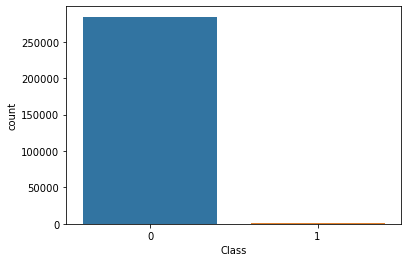

In [7]:
sns.countplot(x = cards_df['Class'])
# dataset is inbalanced

## Data preparation

In [8]:
# Scaling data
rs = RobustScaler()
cards_df['Amount'] = rs.fit_transform(cards_df['Amount'].values.reshape(-1, 1))
cards_df['Time'] = rs.fit_transform(cards_df['Time'].values.reshape(-1, 1))

In [9]:
X = cards_df.drop('Class', axis=1)
y = cards_df['Class']

In [10]:
# split to train and test data to compare it after smot data
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size = 0.25, random_state = RANDOM_SEED)

In [11]:
# Using SMOTE to deal with inbalanced data
smote = SMOTE(random_state=RANDOM_SEED)
X_smot, y_smot = smote.fit_resample(X_train, y_train)

In [12]:
X_train_smot, X_test_smot, y_train_smot, y_test_smot = train_test_split (X_smot,y_smot,
                                                                             test_size = 0.25, random_state = RANDOM_SEED)

<AxesSubplot:xlabel='Class', ylabel='count'>

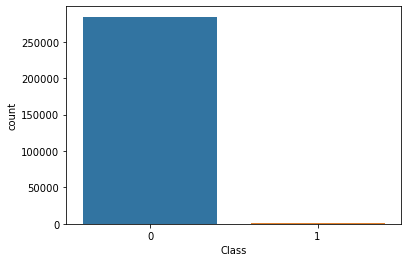

In [13]:
# before SMOT
sns.countplot(x = y)

<AxesSubplot:xlabel='Class', ylabel='count'>

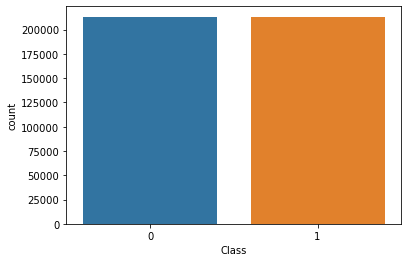

In [14]:
# After SMOT
sns.countplot(x = y_smot)

## Creating model and fitting

In [15]:
MLPC = MLPClassifier()

In [16]:
scoring = ['roc_auc', 'accuracy']
parameter_space = {
    'hidden_layer_sizes': [(140,), (180,), (200,)],
    'max_iter': [500, 1000],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant','adaptive'],}

In [17]:
clf = GridSearchCV(MLPC, parameter_space, n_jobs=-1,  
                   scoring=scoring,  refit='roc_auc', 
                   return_train_score=True)

In [18]:
if fit_model: clf.fit(X_train_smot, y_train_smot)

## Saving model to file

In [19]:
if save_model: joblib.dump(clf, model_filename)

In [20]:
#load your model for further usage
loaded_model = joblib.load(model_filename)

### Best paramete set

In [22]:
print('Best parameters found:\n', loaded_model.best_params_)
print('')
if print_all_cv_results:  [print(param) for param in loaded_model.cv_results_['params']]     

Best parameters found:
 {'alpha': 0.0001, 'hidden_layer_sizes': (180,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}



## Run prediction

In [23]:
y_pred = loaded_model.predict(X_test)

## Comparing scores and results

In [24]:
scores_dict = dict()
scores_dict.update({'accuracy':accuracy_score(y_test,y_pred)})
scores_dict.update({'recall':recall_score (y_test,y_pred)})
scores_dict.update({'f1':f1_score (y_test,y_pred)})
scores_dict.update({'f1 macro':f1_score(y_test, y_pred, average='macro')})
scores_dict.update({'f1 micro':f1_score(y_test, y_pred, average='micro')})
scores_dict.update({'f1 weighted':f1_score(y_test, y_pred, average='weighted')})
scores_df = pd.DataFrame(scores_dict, index = ['scores:'])
scores_df

,accuracy,recall,f1,f1 macro,f1 micro,f1 weighted
scores:,0.999171,0.840708,0.763052,0.881319,0.999171,0.99921


In [25]:
print("AUC score is: {:f}".format(roc_auc_score(y_test, y_pred)))
auprc = average_precision_score(y_test, y_pred)
print("AUPRC score is: {:f}".format(auprc))

AUC score is: 0.920066
AUPRC score is: 0.587512


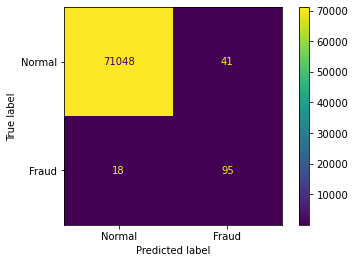

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=loaded_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Normal', 'Fraud'])
disp.plot() 

## Recommend measuring

Text(0.5, 1.0, 'Precision Recall Curve')

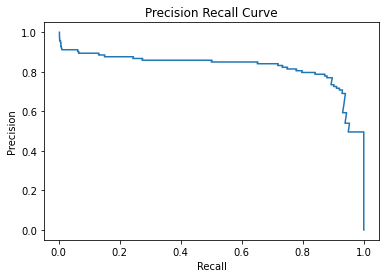

In [27]:
y_pred_prob = loaded_model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')

No Skill: ROC AUC = 0.5
Logistic: ROC AUC = 0.9650695868335055


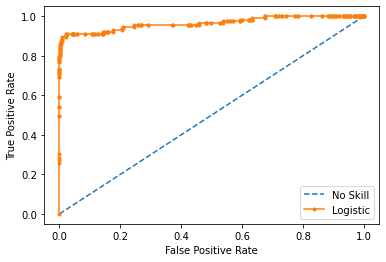

In [28]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = loaded_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC =', (ns_auc))
print('Logistic: ROC AUC =', (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.ylim=(.92, 1.02)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()